In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
asthma = pd.read_csv('codesets/asthma_codeset.csv')
asthma_ids = tuple(asthma['concept_id'])

In [3]:
albuterol = pd.read_csv('codesets/albuterol_codes.csv')
inhaled = albuterol[albuterol['concept_name'].str.contains('inhal', case=False)]

In [4]:
conn = sqlite3.connect("CHOP.db")

In [5]:
# find all people with asthma diagnoses
diagnoses = pd.read_sql_query("SELECT person_id, MIN(visit_start_date) first_diagnosis, \
                                    COUNT(visit_start_date) asthma_visits \
                                FROM (SELECT DISTINCT c.person_id, v.visit_start_date \
                                      FROM condition c INNER JOIN visit v \
                                      ON c.visit_occurrence_id = v.visit_occurrence_id \
                                      WHERE c.condition_concept_id IN {}".format(asthma_ids) + " \
                                          AND v.visit_start_date < '2018-04-02 17:44:00') \
                                GROUP BY person_id", conn)

In [6]:
diagnoses.sort_values('first_diagnosis').head()

,person_id,first_diagnosis,asthma_visits
1526,721,1999-01-12 00:00:00,12
1085,2288,1999-04-28 00:00:00,21
1685,903,1999-06-11 00:00:00,21
1013,2203,1999-08-14 00:00:00,16
1719,939,1999-08-24 00:00:00,9


Earliest date is after earliest birth date. Check to see that number of visits is correct, with duplicate entries resolved for a patient with multiple asthma diagnoses on the same visit.

In [7]:
diagnoses2 = pd.read_sql_query("SELECT c.person_id, c.visit_occurrence_id, v.visit_start_date first_diagnosis\
                                FROM condition c INNER JOIN visit v \
                                ON c.visit_occurrence_id = v.visit_occurrence_id \
                                WHERE c.condition_concept_id IN {}".format(asthma_ids), conn)

In [8]:
diagnoses2[diagnoses2['person_id'] == '2203'].sort_values('visit_occurrence_id')

,person_id,visit_occurrence_id,first_diagnosis
20574,2203,30402,2004-12-29 00:00:00
16320,2203,45634,2008-01-23 00:00:00
5634,2203,52328,2016-01-23 00:00:00
19337,2203,52328,2016-01-23 00:00:00
13476,2203,52519,2011-05-12 00:00:00
8699,2203,54721,2001-07-24 00:00:00
9424,2203,54721,2001-07-24 00:00:00
17107,2203,54748,2010-01-22 00:00:00
7748,2203,54776,2007-01-03 00:00:00
11480,2203,59100,2004-07-12 00:00:00


In [9]:
possibles = diagnoses.loc[diagnoses['asthma_visits'] > 1]

In [10]:
possible_ids = tuple(possibles['person_id'])

In [11]:
albut_scripts = tuple(inhaled['concept_id'])

In [12]:
# Find earliest albuterol prescription for people identified with asthma
scripts = pd.read_sql_query("SELECT person_id, MIN(drug_exposure_start_date) albut_start \
                             FROM drug d \
                             WHERE person_id IN {}".format(possible_ids) + "\
                             AND drug_concept_id IN {}".format(albut_scripts) + "\
                             GROUP BY person_id", conn)

In [13]:
scripts.head()

,person_id,albut_start
0,1000,1899-12-12 00:00:00
1,1001,2009-10-04 00:00:00
2,1003,2007-02-16 00:00:00
3,1006,2003-02-17 00:00:00
4,1007,2002-05-02 00:00:00


In [14]:
asthma_patients_all = diagnoses.set_index('person_id').join(scripts.set_index('person_id'), how='inner')

In [15]:
# Filter out records that have albuterol start dates earlier than first asthma diagnosis
asthma_patients = asthma_patients_all[asthma_patients_all['albut_start'] >= asthma_patients_all['first_diagnosis']]

In [16]:
len(asthma_patients)

918

In [17]:
asthma_patients.head()

,first_diagnosis,asthma_visits,albut_start
person_id,,,
1001,2001-08-10 00:00:00,5,2009-10-04 00:00:00
1003,2003-05-13 00:00:00,8,2007-02-16 00:00:00
1006,2003-02-17 00:00:00,12,2003-02-17 00:00:00
1007,2000-11-20 00:00:00,8,2002-05-02 00:00:00
1011,2002-03-22 00:00:00,7,2006-07-01 00:00:00


In [18]:
# Save as database table to use in subsequent queries
asthma_patients.reset_index().to_sql("asthma", conn, if_exists="replace")

In [19]:
# Find age of first asthma diagnosis
age_first = pd.read_sql_query("SELECT a.person_id, julianday(a.first_diagnosis) first, \
                                    julianday(substr(p.birth_datetime, 1, 10)) birth\
                                 FROM asthma a \
                                 LEFT JOIN person p \
                                 ON a.person_id = p.person_id", conn)
age_first['age_first_d'] = age_first['first'] - age_first['birth']
age_first['age_first_d'] = age_first['age_first_d'].apply(lambda x: round(x/365.25, 1))
age_first = age_first.drop(['first', 'birth'], axis=1).set_index('person_id')
age_first.head()

,age_first_d
person_id,
1001,2.8
1003,1.1
1006,0.5
1007,0.8
1011,2.8


In [20]:
# Filter for people with at least one BMI Z-score >= 1.645; get date of first, count all.
# Average multiple measurements from same date; a couple are different, most are duplicates.

asthma_obese = pd.read_sql_query("SELECT oo.person_id, first_obese, AVG(mmm.value_as_number) BMI_Z, num_obese \
                                  FROM (SELECT o.person_id, num_obese, first_obese \
                                      FROM (SELECT a.person_id, a.first_diagnosis, COUNT(*) num_obese, \
                                              MIN(measurement_date) first_obese \
                                          FROM (SELECT DISTINCT person_id, measurement_date, value_as_number \
                                              FROM measurement \
                                              WHERE measurement_concept_id = '2000000043' \
                                                  AND value_as_number >= 1.645 \
                                                  AND measurement_date < '2018-04-02 17:46:00') AS m \
                                          INNER JOIN asthma a \
                                          ON m.person_id = a.person_id \
                                          GROUP BY a.person_id) AS o\
                                      INNER JOIN measurement mm \
                                      ON o.person_id = mm.person_id\
                                      WHERE mm.measurement_date >= o.first_diagnosis \
                                          AND mm.measurement_concept_id = '2000000043' \
                                          AND value_as_number >= 1.645\
                                      GROUP BY o.person_id) AS oo \
                                  INNER JOIN measurement mmm\
                                  ON oo.person_id = mmm.person_id \
                                  WHERE first_obese = mmm.measurement_date \
                                      AND mmm.measurement_concept_id = '2000000043' \
                                  GROUP BY oo.person_id, first_obese", conn)

In [21]:
asthma_obese.head()

,person_id,first_obese,BMI_Z,num_obese
0,1001,2017-07-25 00:00:00,1.694385,1
1,1024,2002-07-04 00:00:00,1.937813,10
2,1033,2002-02-26 00:00:00,1.706950,18
3,1034,2005-10-05 00:00:00,2.139937,10
4,1037,2003-06-30 00:00:00,2.308346,14


In [22]:
asthma_obese.describe()

,BMI_Z,num_obese
count,380.000000,380.000000
mean,1.957259,9.189474
std,0.266723,6.876283
min,1.645027,1.000000
25%,1.731416,3.000000
50%,1.889878,8.000000
75%,2.130171,13.000000
max,2.843094,30.000000


In [23]:
# Check to make sure no person appears more than once
len(np.unique(list(asthma_obese['person_id'])))

380

In [24]:
# Find difference between 
days = pd.read_sql_query("SELECT person_id, julianday(first_diagnosis) d, julianday(albut_start) a FROM asthma", conn)

In [25]:
days.head()

,person_id,d,a
0,1001,2452131.5,2455108.5
1,1003,2452772.5,2454147.5
2,1006,2452687.5,2452687.5
3,1007,2451868.5,2452396.5
4,1011,2452355.5,2453917.5


In [26]:
days['days_between'] = days['a'] - days['d']
days['days_between'] = days['days_between'].astype('int16')

In [27]:
days.head()

,person_id,d,a,days_between
0,1001,2452131.5,2455108.5,2977
1,1003,2452772.5,2454147.5,1375
2,1006,2452687.5,2452687.5,0
3,1007,2451868.5,2452396.5,528
4,1011,2452355.5,2453917.5,1562


In [28]:
days = days.drop(['d', 'a'], axis=1)

In [29]:
# Combine dataframes generated so far
combined = asthma_patients.join([days.set_index('person_id'), age_first, asthma_obese.set_index('person_id')], how='inner')

In [30]:
for col in ['first_diagnosis', 'albut_start', 'first_obese']:
    combined[col] = combined[col].apply(lambda x: x[:10])

In [31]:
combined.head()

,first_diagnosis,asthma_visits,albut_start,days_between,age_first_d,first_obese,BMI_Z,num_obese
person_id,,,,,,,,
1001,2001-08-10,5,2009-10-04,2977,2.8,2017-07-25,1.694385,1
1024,2004-01-03,19,2004-07-18,197,1.7,2002-07-04,1.937813,10
1033,2003-11-07,14,2003-11-07,0,1.9,2002-02-26,1.706950,18
1034,2005-07-07,3,2005-12-23,169,2.2,2005-10-05,2.139937,10
1037,2002-01-03,10,2007-09-21,2087,1.6,2003-06-30,2.308346,14


In [32]:
len(combined)

380

In [33]:
cohort_ids = tuple(combined.index)

In [34]:
# Pull in demographic data for identified cohort
cohort_demog = pd.read_sql_query("SELECT person_id, birth_datetime [age_(yrs)], gender_concept_id gender, \
                                    ethnicity_concept_id ethnicity, race_concept_id race \
                                  FROM person WHERE person_id IN {}".format(cohort_ids) + "\
                                  ORDER BY person_id", conn)

In [35]:
cohort_demog.head()

,person_id,age_(yrs),gender,ethnicity,race
0,1001,1998-11-08 14:51:52-05,8532,38003564,44814660
1,1024,2002-04-25 01:09:28-04,8507,38003564,8527
2,1033,2001-12-18 00:08:24-05,8532,38003564,8527
3,1034,2003-04-10 05:07:41-04,8507,44814653,8557
4,1037,2000-05-24 00:12:43-04,8507,38003564,8516


In [36]:
# Calculate age as of date the data .csv files were last modified
ref_date = '2018-04-02'
year = float(ref_date[:4])
month = float(ref_date[5:7])
day = float(ref_date[8:10])           
cohort_demog['age_(yrs)'] = cohort_demog['age_(yrs)'].apply(lambda x: round(((30 + day - float(x[8:10])) % 30) / 365 + 
                          ((12 + month - float(x[5:7])) % 12) / 12 + year - float(x[:4]), 1))

In [37]:
# Replace database codes with the values they represent, shortened as appropriate
gender = {'8532': 'F', 'F': 'F', '8507': 'M', 'M': 'M', '44814649': 'Other', '44814650': 'No info', '44814653': 'Unknown'}
race = {'8515': 'Asian', '8516': 'Bl/AfrAm', '8527': 'White', '8557': 'Hawaii/PacIsl', '8657': 'AmInd/Alaska',
       '44814649': 'Other', '44814650': 'No info', '44814653': 'Unknown', '44814659': 'Multiple', '44814660': 'Declined'}
ethnicity = {'38003563': 'Hisp/Lat', '38003564': 'Not Hisp/Lat', '44814649': 'Other', '44814650': 'No info', '44814653': 'Unknown'}

In [38]:
cols = ['gender', 'ethnicity', 'race']
decoders = [gender, ethnicity, race]
for col, decode in zip(cols, decoders):
    cohort_demog[col] = cohort_demog[col].apply(lambda x: decode[x])

In [39]:
cohort_demog.head()

,person_id,age_(yrs),gender,ethnicity,race
0,1001,20.5,F,Not Hisp/Lat,Declined
1,1024,16.0,M,Not Hisp/Lat,White
2,1033,17.4,F,Not Hisp/Lat,White
3,1034,15.1,M,Unknown,Hawaii/PacIsl
4,1037,18.9,M,Not Hisp/Lat,Bl/AfrAm


In [40]:
cohort_demog['age_(yrs)'].min()

13.1

In [41]:
cohort_demog['age_(yrs)'].max()

20.699999999999999

In [42]:
cohort = cohort_demog.set_index('person_id').join(combined)

In [43]:
cohort.head()

,age_(yrs),gender,ethnicity,race,first_diagnosis,asthma_visits,albut_start,days_between,age_first_d,first_obese,BMI_Z,num_obese
person_id,,,,,,,,,,,,
1001,20.5,F,Not Hisp/Lat,Declined,2001-08-10,5,2009-10-04,2977,2.8,2017-07-25,1.694385,1
1024,16.0,M,Not Hisp/Lat,White,2004-01-03,19,2004-07-18,197,1.7,2002-07-04,1.937813,10
1033,17.4,F,Not Hisp/Lat,White,2003-11-07,14,2003-11-07,0,1.9,2002-02-26,1.706950,18
1034,15.1,M,Unknown,Hawaii/PacIsl,2005-07-07,3,2005-12-23,169,2.2,2005-10-05,2.139937,10
1037,18.9,M,Not Hisp/Lat,Bl/AfrAm,2002-01-03,10,2007-09-21,2087,1.6,2003-06-30,2.308346,14


In [44]:
# Reformat table for more logical column order
cohort = cohort.reset_index()
cols = cohort.columns.tolist()
new_cols = cols[:6] + cols[7:10] + [cols[6]] + cols[10:]
cohort = cohort[new_cols]
cohort.head()

,person_id,age_(yrs),gender,ethnicity,race,first_diagnosis,albut_start,days_between,age_first_d,asthma_visits,first_obese,BMI_Z,num_obese
0,1001,20.5,F,Not Hisp/Lat,Declined,2001-08-10,2009-10-04,2977,2.8,5,2017-07-25,1.694385,1
1,1024,16.0,M,Not Hisp/Lat,White,2004-01-03,2004-07-18,197,1.7,19,2002-07-04,1.937813,10
2,1033,17.4,F,Not Hisp/Lat,White,2003-11-07,2003-11-07,0,1.9,14,2002-02-26,1.706950,18
3,1034,15.1,M,Unknown,Hawaii/PacIsl,2005-07-07,2005-12-23,169,2.2,3,2005-10-05,2.139937,10
4,1037,18.9,M,Not Hisp/Lat,Bl/AfrAm,2002-01-03,2007-09-21,2087,1.6,10,2003-06-30,2.308346,14


In [45]:
cohort_stats = cohort.describe()
cohort_stats

,age_(yrs),days_between,age_first_d,asthma_visits,BMI_Z,num_obese
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000
mean,17.017105,663.650000,1.801842,11.465789,1.957259,9.189474
std,1.791683,852.712154,1.358768,5.520543,0.266723,6.876283
min,13.100000,0.000000,0.300000,2.000000,1.645027,1.000000
25%,15.575000,14.000000,0.900000,7.000000,1.731416,3.000000
50%,17.100000,350.000000,1.400000,11.000000,1.889878,8.000000
75%,18.525000,980.750000,2.200000,16.000000,2.130171,13.000000
max,20.700000,3923.000000,11.400000,25.000000,2.843094,30.000000


In [46]:
# Total number of obese measurements for a reality check
cohort['num_obese'].sum()

3492

In [47]:
# Set up dicts to decode conditions and scripts
keys = asthma['concept_id']
values = asthma['concept_name']
asthma_dict = dict(zip(keys, values))

keys = albuterol['concept_id']
values = albuterol['concept_name']
albut_dict = dict(zip(keys, values))

In [48]:
# Select info for visits table; then post-process into readable form
visits = pd.read_sql_query("SELECT v.person_id p_id, v.visit_start_date date, p.birth_datetime age, \
                                p.gender_concept_id gender, \
                                AVG(m.value_as_number) obese, \
                                GROUP_CONCAT(c.condition_concept_id) diagnoses, \
                                GROUP_CONCAT(d.drug_concept_id) scripts \
                            FROM visit v INNER JOIN person p ON v.person_id = p.person_id \
                            LEFT JOIN condition c on v.visit_occurrence_id = c.visit_occurrence_id \
                            LEFT JOIN drug d on v.visit_occurrence_id = d.visit_occurrence_id \
                            LEFT JOIN (SELECT visit_occurrence_id, value_as_number \
                                        FROM measurement \
                                        WHERE measurement_concept_id = '2000000043') m \
                            ON v.visit_occurrence_id = m.visit_occurrence_id \
                            WHERE v.person_id IN {}".format(cohort_ids) + " \
                                AND v.visit_start_date < '2018-04-02 17:44:00' \
                                AND v.visit_concept_id = '9201'\
                            GROUP BY v.person_id, v.visit_start_date \
                            ORDER BY v.person_id, v.visit_start_date", conn)

In [49]:
visits['obese'] = visits['obese'].astype('float16')

In [50]:
age_list = []
for row in visits.itertuples():
    age_list.append(round(((30 + float(row.date[8:10]) - float(row.age[8:10])) % 30) / 365 + 
                          ((12 + float(row.date[5:7]) - float(row.age[5:7])) % 12) / 12 + 
                          float(row.date[:4]) - float(row.age[:4]), 1))
visits.loc[:, 'age'] = age_list

In [51]:
visits['date'] = visits['date'].apply(lambda x: x[:10])
visits['gender'] = visits['gender'].apply(lambda x: gender[x])
visits['obese'] = visits['obese'].apply(lambda x: 'no' if np.isnan(x) or x < 1.645 else 'yes')
cols = ['diagnoses', 'scripts']
decoders = [asthma_dict, albut_dict]
for col, decode in zip(cols, decoders):
    visits.loc[:, col] = visits[col].apply(lambda x: '—' if not x else [decode.get(item, 'x') for item in 
                                                                [int(s) for s in (set(x.split(',')))]])

In [52]:
visits.columns = ['p_id', 'visit_date', 'age_(yrs)', 'gender', 'obese', 'diagnoses (asthma, x = other)', 
                  'scripts (albuterol, x = other)']

In [53]:
visits.head()

,p_id,visit_date,age_(yrs),gender,obese,"diagnoses (asthma, x = other)","scripts (albuterol, x = other)"
0,1001,2007-12-14,9.1,F,no,[x],[x]
1,1001,2017-07-25,19.7,F,yes,"[Uncomplicated asthma, x]",—
2,1024,2011-10-24,9.6,M,no,—,[x]
3,1037,2012-10-22,12.5,M,no,"[x, Asthma]",—
4,1049,2001-09-08,3.0,F,no,"[x, x]",[200 ACTUAT Albuterol 0.09 MG/ACTUAT Metered D...


In [54]:
visits.describe()

,age_(yrs)
count,428.000000
mean,6.835514
std,5.223492
min,0.000000
25%,2.300000
50%,5.550000
75%,11.000000
max,19.700000


In [55]:
visits_stats = visits.describe()
visits['visit_date'].min()

'1999-05-17'

Earliest visit date is later than earliest birth date.

In [56]:
# How many of the cohort had in-patient visits
len(np.unique(visits['p_id']))

267

In [57]:
# Select info for BMI table; post-process into readable form
bmi = pd.read_sql_query("SELECT v.person_id p_id, v.visit_start_date date, p.birth_datetime age, \
                                p.gender_concept_id gender, \
                                AVG(m.value_as_number) BMI_Z, \
                                AVG(t.value_as_number) [body_temp_(C)], \
                                AVG(h.value_as_number) heart_rate, \
                                GROUP_CONCAT(c.condition_concept_id) asthma_diagnosis\
                            FROM visit v INNER JOIN person p ON v.person_id = p.person_id \
                                INNER JOIN measurement m ON v.visit_occurrence_id = m.visit_occurrence_id \
                                LEFT JOIN (SELECT value_as_number, visit_occurrence_id \
                                            FROM measurement \
                                            WHERE measurement_concept_id = '3020891') t\
                                ON v.visit_occurrence_id = t.visit_occurrence_id \
                                LEFT JOIN (SELECT value_as_number, visit_occurrence_id \
                                            FROM measurement \
                                            WHERE measurement_concept_id = '3027018') h \
                                ON v.visit_occurrence_id = h.visit_occurrence_id \
                                LEFT JOIN (SELECT condition_concept_id, visit_occurrence_id \
                                            FROM condition) c \
                                ON v.visit_occurrence_id = c.visit_occurrence_id\
                            WHERE v.person_id IN {}".format(cohort_ids) + " \
                                AND measurement_concept_id = '2000000043' \
                                AND v.visit_start_date < '2018-04-02 17:44:00' \
                            GROUP BY v.person_id, v.visit_start_date \
                            ORDER BY v.person_id, v.visit_start_date", conn)

In [58]:
bmi.head(10)

,p_id,date,age,gender,BMI_Z,body_temp_(C),heart_rate,asthma_diagnosis
0,1001,2000-11-28 00:00:00,1998-11-08 14:51:52-05,8532,1.304754,37.876554,99.0,"432526,432526,432526,432526,432526,432526,4325..."
1,1001,2002-01-16 00:00:00,1998-11-08 14:51:52-05,8532,1.396109,NaN,NaN,None
2,1001,2002-12-17 00:00:00,1998-11-08 14:51:52-05,8532,0.952914,NaN,NaN,4061660
3,1001,2003-09-18 00:00:00,1998-11-08 14:51:52-05,8532,1.059959,NaN,NaN,None
4,1001,2003-09-23 00:00:00,1998-11-08 14:51:52-05,8532,1.472771,NaN,NaN,"375415,375415"
5,1001,2003-12-24 00:00:00,1998-11-08 14:51:52-05,8532,1.398924,NaN,NaN,None
6,1001,2006-02-25 00:00:00,1998-11-08 14:51:52-05,8532,1.357291,NaN,NaN,"4143828,4203711"
7,1001,2007-08-07 00:00:00,1998-11-08 14:51:52-05,8532,1.296440,NaN,NaN,None
8,1001,2008-11-12 00:00:00,1998-11-08 14:51:52-05,8532,1.555401,37.956883,NaN,45771045
9,1001,2009-10-04 00:00:00,1998-11-08 14:51:52-05,8532,1.529955,NaN,102.0,"377889,443364"


In [59]:
bmi.describe()

,BMI_Z,body_temp_(C),heart_rate
count,5656.000000,580.000000,711.000000
mean,1.802211,37.488201,87.158931
std,0.397917,0.818511,26.432136
min,0.712028,35.583251,22.000000
25%,1.501755,36.853343,69.000000
50%,1.768891,37.461323,85.000000
75%,2.097774,38.007019,102.000000
max,2.900822,40.113077,160.000000


In [60]:
bmi_stats = bmi.describe()
bmi['date'].min()

'1999-02-22 00:00:00'

Some heart rates seem very low, but not unimaginably so. All other values are reasonable, and the earliest measurement date is later than the earliest birth date.

In [61]:
# For boolean column to indicate whether an asthma diagnosis was made during the same visit
asthma_ids_2 = set([str(id) for id in asthma_ids])

In [62]:
age_list = []
for row in bmi.itertuples():
    age_list.append(round(((30 + float(row.date[8:10]) - float(row.age[8:10])) % 30) / 365 + 
                          ((12 + float(row.date[5:7]) - float(row.age[5:7])) % 12) / 12 + 
                          float(row.date[:4]) - float(row.age[:4]), 1))
bmi.loc[:, 'age'] = age_list

bmi['date'] = bmi['date'].apply(lambda x: x[:10])
bmi['gender'] = bmi['gender'].apply(lambda x: gender[x])
bmi['BMI_Z'] = bmi['BMI_Z'].apply(lambda x: round(x, 3))
bmi['body_temp_(C)'] = bmi['body_temp_(C)'].apply(lambda x: '—' if np.isnan(x) else round(x, 1))
bmi['heart_rate'] = bmi['heart_rate'].apply(lambda x: '—' if np.isnan(x) else int(x))
bmi['asthma_diagnosis'] = bmi['asthma_diagnosis'].apply(lambda x: 'no' if not x or not (set(x.split(',')) & asthma_ids_2) else 'yes')

In [63]:
bmi.columns = ['age_(yrs)' if name == 'age' else name for name in bmi.columns]

In [64]:
bmi.head()

,p_id,date,age_(yrs),gender,BMI_Z,body_temp_(C),heart_rate,asthma_diagnosis
0,1001,2000-11-28,2.1,F,1.305,37.9,99,no
1,1001,2002-01-16,4.2,F,1.396,—,—,no
2,1001,2002-12-17,4.1,F,0.953,—,—,no
3,1001,2003-09-18,5.9,F,1.060,—,—,no
4,1001,2003-09-23,5.9,F,1.473,—,—,no


In [65]:
bmi.describe()

,age_(yrs),BMI_Z
count,5656.000000,5656.000000
mean,8.645138,1.802210
std,4.454759,0.397914
min,0.000000,0.712000
25%,4.900000,1.502000
50%,8.400000,1.769000
75%,12.200000,2.098000
max,20.300000,2.901000


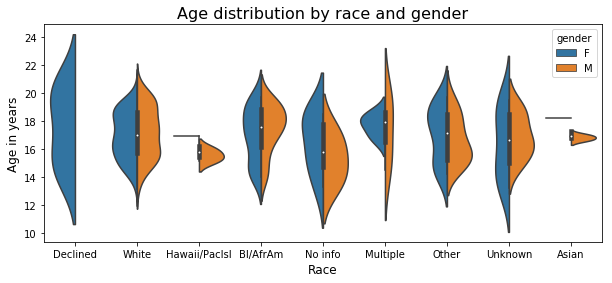

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.catplot(ax=ax, x='race', y='age_(yrs)', hue='gender', kind='violin', split=True, data=cohort)
plt.close(2)
plt.title('Age distribution by race and gender', size=16)
plt.xlabel('Race', size=12)
plt.ylabel('Age in years', size=12)
plt.show()
#fig.savefig('age_race_gender.png')
fig.savefig('age_race_gender.jpg')

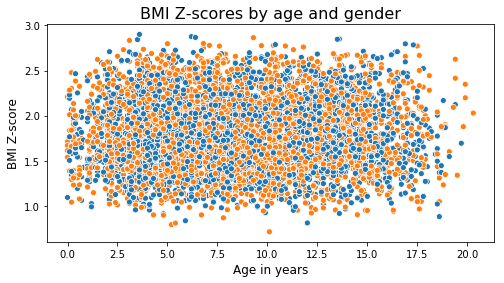

In [67]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.relplot(ax=ax, x='age_(yrs)', y='BMI_Z', hue="gender", data=bmi)
plt.close(2)
plt.title('BMI Z-scores by age and gender', size=16)
plt.xlabel('Age in years', size=12)
plt.ylabel('BMI Z-score', size=12)
plt.show()
#fig.savefig('bmi_age_gender.png')
fig.savefig('bmi_age_gender.jpg')

Calculate some general stats.

In [68]:
total = len(cohort)
HL = len(cohort[cohort['ethnicity'] == 'Hisp/Lat'])
not_HL = len(cohort[cohort['ethnicity'] == 'Not Hisp/Lat'])
tot_ethn = HL + not_HL

print('Of the {}% of the cohort with known ethnicity, {}% identified as Hispanic or Latino.'.format(
        round((tot_ethn/total)*100, 1), round((HL/tot_ethn)*100, 1)))

Of the 86.8% of the cohort with known ethnicity, 15.2% identified as Hispanic or Latino.


In [69]:
male = len(cohort[cohort['gender'] == 'M'])
female = len(cohort[cohort['gender'] == 'F'])
print('male: {}, female: {}'.format(male, female))

male: 193, female: 187


In [70]:
declined = len(cohort[cohort['race'] == 'Declined'])
no_info = len(cohort[cohort['race'] == 'No info'])
unknown = len(cohort[cohort['race'] == 'Unknown'])
known = total - (declined + no_info + unknown)
known_pct = round(100 * known / total, 1)

white = round(100 * len(cohort[cohort['race'] == 'White']) / known, 1)
bl_afram = round(100* len(cohort[cohort['race'] == 'Bl/AfrAm']) / known, 1)
other = round(100 * len(cohort[cohort['race'] == 'Other']) / known, 1)
mult_count = len(cohort[cohort['race'] == 'Multiple'])
mult = round(100 * mult_count / known, 1)
hp_count = len(cohort[cohort['race'] == 'Hawaii/PacIsl'])
hp = round(100 * hp_count / known, 1)
asian_count = len(cohort[cohort['race'] == 'Asian'])
asian = round(100 * asian_count / known, 1)

print('white: {}, bl/AfrAm: {}, other: {}, mult: {}, HP: {}, Asian: {}'.format(white, bl_afram, other, mult, hp, asian))
print('mult: {}, HP: {}, Asian: {}'.format(mult_count, hp_count, asian_count))

print('Known race: {}%'.format(known_pct))
print('total: {}'.format(total))

white: 70.4, bl/AfrAm: 16.8, other: 8.4, mult: 2.0, HP: 1.2, Asian: 1.2
mult: 7, HP: 4, Asian: 4
Known race: 90.8%
total: 380


In [71]:
print('Race information is available for almost all, {}%, of the cohort. Among known racial identities whites \
predominate at {}%, with blacks or African Americans next at {}%. People of multiple racial ancestry \
form {}% of the cohort. These percentages all are comparable to current Census Bureau figures for the US \
population as a whole. Of the other identified groups, both at {}%, Asians are represented at about one-fifth of \
their presence in the general population, while those of Hawaiian or other Pacific island ancestry are conversely \
represented at about five times the national average. Notably, the cohort contains no one identified as of \
American Indian or native Alaskan ancestry.'.format(known_pct, white, bl_afram, mult, asian, hp))

Race information is available for almost all, 90.8%, of the cohort. Among known racial identities whites predominate at 70.4%, with blacks or African Americans next at 16.8%. People of multiple racial ancestry form 2.0% of the cohort. These percentages all are comparable to current Census Bureau figures for the US population as a whole. Of the other identified groups, both at 1.2%, Asians are represented at about one-fifth of their presence in the general population, while those of Hawaiian or other Pacific island ancestry are conversely represented at about five times the national average. Notably, the cohort contains no one identified as of American Indian or native Alaskan ancestry.


In [72]:
#cohort.to_csv('cohort.csv')
#visits.to_csv('inpatient_visits.csv')
#bmi.to_csv('bmi.csv')

In [73]:
print(cohort_stats.columns.tolist())
print(bmi_stats.columns.tolist())
print(visits_stats.columns.tolist())

['age_(yrs)', 'days_between', 'age_first_d', 'asthma_visits', 'BMI_Z', 'num_obese']
['BMI_Z', 'body_temp_(C)', 'heart_rate']
['age_(yrs)']


In [75]:
stats = cohort_stats.join(bmi_stats, lsuffix='1')
stats = stats.join(visits_stats, lsuffix='1')
stats

,age_(yrs)1,days_between,age_first_d,asthma_visits,BMI_Z1,num_obese,BMI_Z,body_temp_(C),heart_rate,age_(yrs)
count,380.000000,380.000000,380.000000,380.000000,380.000000,380.000000,5656.000000,580.000000,711.000000,428.000000
mean,17.017105,663.650000,1.801842,11.465789,1.957259,9.189474,1.802211,37.488201,87.158931,6.835514
std,1.791683,852.712154,1.358768,5.520543,0.266723,6.876283,0.397917,0.818511,26.432136,5.223492
min,13.100000,0.000000,0.300000,2.000000,1.645027,1.000000,0.712028,35.583251,22.000000,0.000000
25%,15.575000,14.000000,0.900000,7.000000,1.731416,3.000000,1.501755,36.853343,69.000000,2.300000
50%,17.100000,350.000000,1.400000,11.000000,1.889878,8.000000,1.768891,37.461323,85.000000,5.550000
75%,18.525000,980.750000,2.200000,16.000000,2.130171,13.000000,2.097774,38.007019,102.000000,11.000000
max,20.700000,3923.000000,11.400000,25.000000,2.843094,30.000000,2.900822,40.113077,160.000000,19.700000


In [76]:
obese = asthma_obese[['person_id', 'first_obese']]
obese.to_sql("obese", conn, if_exists="replace")

In [77]:
obese_1 = pd.read_sql_query("SELECT julianday(substr(p.birth_datetime, 1, 10)) birth, \
                                    julianday(o.first_obese) first\
                             FROM person p\
                             INNER JOIN obese o\
                             ON p.person_id = o.person_id", conn)

In [78]:
obese_1['age'] = obese_1['first'] - obese_1['birth']
obese_1['age'] = obese_1['age'] / 365.25

In [79]:
obese_1.describe()

,birth,first,age
count,3.800000e+02,3.800000e+02,380.000000
mean,2.452254e+06,2.453483e+06,3.364105
std,6.275311e+02,1.331143e+03,3.177869
min,2.451046e+06,2.451240e+06,0.010951
25%,2.451720e+06,2.452557e+06,1.370294
50%,2.452256e+06,2.453222e+06,2.491444
75%,2.452794e+06,2.453988e+06,3.955510
max,2.453550e+06,2.458200e+06,18.710472
